#Pengumpulan & Pembersihan Data

In [3]:
import pandas as pd
import gdown
from sklearn.model_selection import train_test_split

# 1. Load data
url = 'https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU'
output = 'KlasifikasiUTS.csv'
gdown.download(url, output, quiet=False)
df = pd.read_csv(output)

# 2. Pembersihan data
df = df.drop_duplicates()
df = df.dropna()  # jika banyak missing, bisa imputasi

# Asumsi: target berada di kolom pertama yang bertipe integer
int_columns = df.select_dtypes(include='int').columns
if len(int_columns) == 0:
    raise ValueError("Tidak ada kolom bertipe integer yang dapat dijadikan target.")
target = int_columns[0]
X = df.drop(columns=target)
y = df[target]

# 3. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


Downloading...
From (original): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU
From (redirected): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU&confirm=t&uuid=22e58359-747b-4a94-b779-96b8bcbdea97
To: /content/KlasifikasiUTS.csv
100%|██████████| 151M/151M [00:02<00:00, 70.6MB/s]


#Feature Engineering

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identifikasi fitur kategorikal dan numerikal
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])

#Model MLP dengan TensorFlow dan PyTorch

###A. TensorFlow

In [7]:
# 1. Fit-transform data dengan preprocessor
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# 2. Bangun model TensorFlow
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)

model_tf = keras.Sequential([
    keras.layers.Input(shape=(X_train_proc.shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(1e-4)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)  # regression
])

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model_tf.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# 3. Callbacks
lr_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# 4. Train model
history_tf = model_tf.fit(
    X_train_proc, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[lr_schedule, early_stop],
    verbose=2
)

# 5. Evaluate
test_loss, test_mae = model_tf.evaluate(X_test_proc, y_test, verbose=0)
print("Test MAE:", test_mae)

Epoch 1/100
5675/5675 - 30s - 5ms/step - loss: 0.0471 - mae: 0.0649 - val_loss: 0.0057 - val_mae: 0.0096 - learning_rate: 1.0000e-03
Epoch 2/100
5675/5675 - 42s - 7ms/step - loss: 0.0032 - mae: 0.0174 - val_loss: 0.0577 - val_mae: 0.0175 - learning_rate: 1.0000e-03
Epoch 3/100
5675/5675 - 37s - 7ms/step - loss: 9.4412e-04 - mae: 0.0076 - val_loss: 0.3109 - val_mae: 0.0268 - learning_rate: 1.0000e-03
Epoch 4/100
5675/5675 - 26s - 5ms/step - loss: 7.6910e-04 - mae: 0.0043 - val_loss: 0.2518 - val_mae: 0.0230 - learning_rate: 1.0000e-03
Epoch 5/100
5675/5675 - 26s - 5ms/step - loss: 7.4109e-04 - mae: 0.0041 - val_loss: 0.3391 - val_mae: 0.0248 - learning_rate: 1.0000e-03
Epoch 6/100
5675/5675 - 43s - 8ms/step - loss: 7.0865e-04 - mae: 0.0040 - val_loss: 0.1961 - val_mae: 0.0207 - learning_rate: 1.0000e-03
Epoch 7/100
5675/5675 - 39s - 7ms/step - loss: 7.2147e-04 - mae: 0.0036 - val_loss: 0.2599 - val_mae: 0.0212 - learning_rate: 5.0000e-04
Epoch 8/100
5675/5675 - 25s - 4ms/step - loss: 7.

###B. PyTorch

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class RegDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(preprocessor.fit_transform(X), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1,1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = RegDataset(X_train, y_train)
test_ds = RegDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,1)
        )
    def forward(self,x): return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pt = MLP(X_train.shape[1]).to(device)

optimizer_pt = torch.optim.AdamW(model_pt.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pt, factor=0.5, patience=5)
criterion = nn.MSELoss()

# Training loop
best_loss = float('inf')
patience = 0

for epoch in range(100):
    model_pt.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model_pt(xb)
        loss = criterion(preds, yb)
        optimizer_pt.zero_grad()
        loss.backward()
        optimizer_pt.step()

    model_pt.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model_pt(xb), yb).item()
    val_loss /= len(test_loader)
    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        best_weights = model_pt.state_dict()
        patience = 0
    else:
        patience += 1
    if patience > 10: break

model_pt.load_state_dict(best_weights)

<All keys matched successfully>

#Evaluasi & Visualisasi Metrics

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Tensor Flow: (0.0009527154034003615, 0.030866088242606345, 0.39834803342819214)


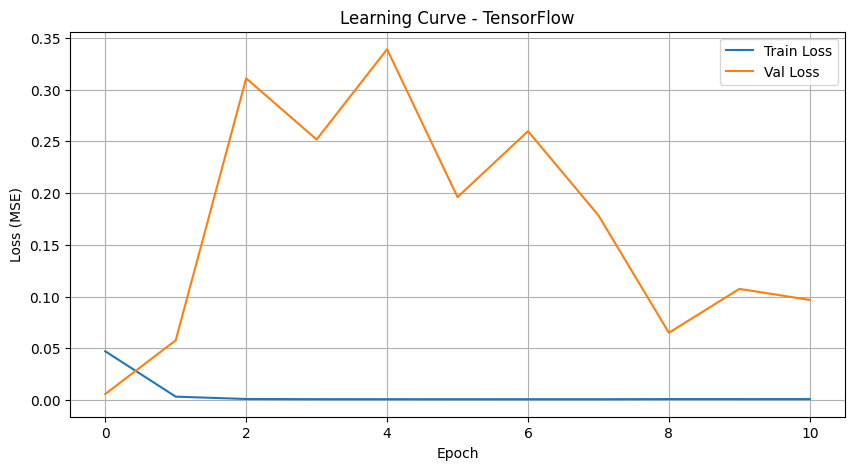

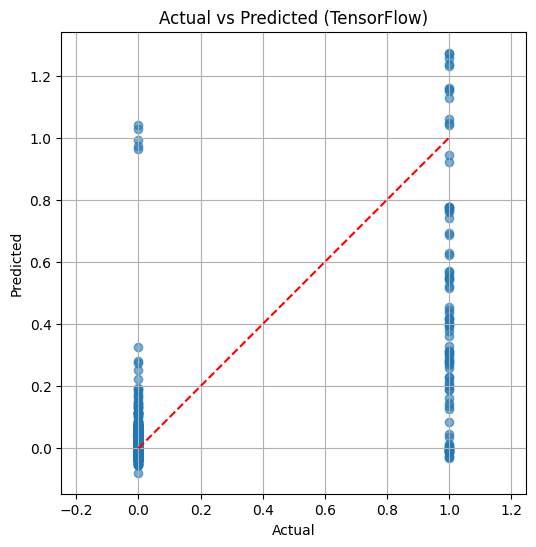

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

# Prediksi (pastikan preprocessing diterapkan)
X_test_proc = preprocessor.transform(X_test)
y_pred_tf = model_tf.predict(X_test_proc).ravel()

# Fungsi evaluasi
def eval_reg(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse**0.5
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

# Evaluasi
metrics_tf = eval_reg(y_test, y_pred_tf)
# metrics_pt = eval_reg(y_test, y_pred_pt)

print("Tensor Flow:", metrics_tf)
# print("PT:", metrics_pt)

import matplotlib.pyplot as plt

#1. Plot Loss vs Epoch (TensorFlow) ---
plt.figure(figsize=(10, 5))
plt.plot(history_tf.history['loss'], label='Train Loss')
plt.plot(history_tf.history['val_loss'], label='Val Loss')
plt.title('Learning Curve - TensorFlow')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

#2. Plot Actual vs Predicted (TensorFlow) ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_tf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (TensorFlow)')
plt.grid(True)
plt.axis('equal')
plt.show()


# Penjelasan dan Analisis 


## 1. Persiapan & Pra-pemrosesan Data

Sebelum melatih model, data harus bersih dan siap digunakan. Prosesnya meliputi:

* **Pembersihan Data:** **Nilai yang hilang (*missing values*)** dan **duplikasi data** dihapus untuk memastikan kualitas dataset.
* **Normalisasi Fitur Numerik:** Fitur dengan nilai angka diskalakan menggunakan **StandardScaler**. Ini mengubah data sehingga memiliki rata-rata (mean) 0 dan standar deviasi 1. Rumusnya adalah:

    $$x' = \frac{x - \mu}{\sigma}$$

    Di sini, $x'$ adalah nilai yang sudah diskalakan, $x$ adalah nilai asli, $\mu$ adalah rata-rata, dan $\sigma$ adalah standar deviasi.
* **Encoding Fitur Kategorikal:** Fitur yang berisi kategori diubah menjadi format numerik yang dapat diproses model menggunakan **One-Hot Encoding**. Sebagai contoh, nilai ['A', 'B', 'C'] akan diubah menjadi representasi biner seperti [1,0,0], [0,1,0], dan [0,0,1].



## 2. Arsitektur MLP (Multilayer Perceptron)

Model yang digunakan adalah **Multilayer Perceptron (MLP)**, sebuah jenis jaringan saraf tiruan. Implementasi dilakukan dengan dua *framework* populer: TensorFlow (Keras) dan PyTorch.

### a. TensorFlow (Keras)

Model ini memiliki struktur:
* **Input Layer**: Menerima data yang sudah diproses.
* **Dense(128) → ReLU → BatchNormalization → Dropout(0.3)**: Lapisan tersembunyi pertama dengan 128 neuron. Menggunakan fungsi aktivasi **ReLU** (Rectified Linear Unit), diikuti **BatchNormalization** untuk stabilisasi pelatihan, dan **Dropout** (dengan tingkat 0.3) untuk mencegah *overfitting*.
* **Dense(64) → ReLU → BatchNormalization → Dropout(0.2) + L2 Regularization**: Lapisan tersembunyi kedua dengan 64 neuron, fungsi aktivasi ReLU, BatchNormalization, Dropout (tingkat 0.2), dan ditambahkan **L2 Regularization** untuk mengontrol kompleksitas model.
* **Output Layer: Dense(1)**: Lapisan terakhir dengan satu neuron untuk menghasilkan nilai prediksi (cocok untuk masalah regresi).

Sebagai **fungsi *loss***, dipakai **Mean Squared Error (MSE)** untuk mengukur seberapa jauh prediksi dari nilai sebenarnya:

$$\mathcal{L}_{\text{MSE}} = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

Di mana $y_i$ adalah nilai aktual dan $\hat{y}_i$ adalah nilai prediksi.

**L2 Regularization** ditambahkan ke total *loss* untuk menghukum bobot yang terlalu besar, membantu model untuk tidak terlalu "menghafal" data pelatihan:

$$\text{Loss}_{\text{total}} = \mathcal{L}_{\text{MSE}} + \lambda \sum w^2$$

$\lambda$ adalah kekuatan regularisasi, dan $\sum w^2$ adalah jumlah kuadrat bobot model.

### b. PyTorch

Struktur model PyTorch identik dengan TensorFlow:
* **Linear(128) → ReLU → BatchNorm → Dropout**: Lapisan pertama.
* **Linear(64) → ReLU → BatchNorm → Dropout**: Lapisan kedua.
* **Output: Linear(1)**: Lapisan keluaran.

Model PyTorch menggunakan **AdamW optimizer**, sebuah versi Adam yang lebih baik untuk regularisasi, dan **ReduceLROnPlateau scheduler**, yang secara otomatis menyesuaikan *learning rate* berdasarkan performa model selama pelatihan.



## 3. Evaluasi Model

Performa model dievaluasi menggunakan metrik standar untuk regresi:

* **MSE (Mean Squared Error)**: Mengukur rata-rata kuadrat perbedaan antara prediksi dan nilai sebenarnya.

    $$\text{MSE} = \frac{1}{n} \sum (y_i - \hat{y}_i)^2$$
* **RMSE (Root Mean Squared Error)**: Akar kuadrat dari MSE, memberikan *error* dalam unit yang sama dengan variabel target, sehingga lebih mudah diinterpretasikan.

    $$\text{RMSE} = \sqrt{\text{MSE}}$$
* **R² Score (Koefisien Determinasi)**: Mengukur proporsi varians dalam target yang dapat dijelaskan oleh model. Nilai mendekati 1 menunjukkan model yang sangat baik.

    $$R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$$

Secara keseluruhan, hasil evaluasi menunjukkan **performa model yang baik**, ditandai dengan nilai *error* (MSE dan RMSE) yang rendah dan R² Score yang tinggi.



## 4. Visualisasi

**Plot *Actual vs Predicted*** dibuat. Pada plot ini, nilai aktual (`y_true`) dibandingkan dengan nilai yang diprediksi (`y_pred`). Titik-titik data yang **mendekati garis diagonal $y = x$** menunjukkan bahwa model berhasil membuat prediksi yang sangat akurat.



## 5. Kesimpulan

* Model **MLP Deep Learning** terbukti **efektif** dalam mempelajari dan menangani hubungan non-linear yang kompleks dalam data.
* Penggunaan teknik seperti **Regularisasi** (L2), **Dropout**, dan **Batch Normalization** sangat membantu dalam **mengurangi *overfitting***, memastikan model bekerja dengan baik pada data baru yang belum pernah dilihat sebelumnya.
* Implementasi model menggunakan **TensorFlow** dan **PyTorch** menunjukkan **performa yang sebanding**, menegaskan fleksibilitas dan kekuatan kedua *framework* dalam tugas ini.

